In [12]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from joblib import dump
from src.models import eval_model as evm
from src.models import eval_baseline as evb
from sklearn.utils import resample
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
df = pd.read_csv("../data/processed/df_cleaned_nba_prediction.csv")

In [7]:
df

,GP,MIN,PTS,FGM,FGA,3P Made,3PA,FTM,FTA,OREB,...,REB,AST,STL,BLK,TOV,TARGET_5Yrs,CALC3P%,CALCFG%,CALCFT%,TARGET_5Yrs_Inv
0,80,24.3,7.8,3.0,6.4,0.1,0.3,2.0,2.9,2.2,...,3.8,3.2,1.1,0.2,1.6,1,33.333333,46.875000,68.965517,0
1,75,21.8,10.5,4.2,7.9,0.0,0.0,2.4,3.6,3.6,...,6.6,0.7,0.5,0.6,1.4,1,0.000000,53.164557,66.666667,0
2,85,19.1,4.5,1.9,4.5,0.4,1.2,0.4,0.6,0.6,...,2.4,0.8,0.4,0.2,0.6,1,33.333333,42.222222,66.666667,0
3,63,19.1,8.2,3.5,6.7,0.3,0.8,0.9,1.5,0.8,...,3.0,1.8,0.4,0.1,1.9,1,37.500000,52.238806,60.000000,0
4,63,17.8,3.7,1.7,3.4,0.5,1.4,0.2,0.5,2.4,...,4.9,0.4,0.4,0.6,0.7,1,35.714286,50.000000,40.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,32,9.2,1.8,0.7,1.8,0.0,0.0,0.4,0.6,0.3,...,1.9,0.5,0.3,0.2,0.4,1,0.000000,38.888889,66.666667,0
7996,54,6.0,1.8,0.7,1.4,0.1,0.1,0.2,0.4,1.0,...,2.0,0.1,0.0,0.3,0.3,1,100.000000,50.000000,50.000000,0
7997,85,28.2,10.7,4.0,9.0,0.2,0.6,2.8,3.9,1.0,...,3.1,3.4,1.2,0.2,1.8,1,33.333333,44.444444,71.794872,0
7998,39,7.7,2.5,1.0,2.3,0.0,0.0,0.6,0.7,0.4,...,0.9,0.2,0.3,0.3,0.5,1,0.000000,43.478261,85.714286,0


In [10]:
df_minority = df[df['TARGET_5Yrs_Inv']==1]
df_majority = df[df['TARGET_5Yrs_Inv']==0]

In [11]:
[df_minority.shape , df_majority.shape]

[(1331, 21), (6669, 21)]

In [16]:
df_minority['TARGET_5Yrs_Inv'].value_counts(), df_majority['TARGET_5Yrs_Inv'].value_counts()

(1    1331
 Name: TARGET_5Yrs_Inv, dtype: int64,
 0    6669
 Name: TARGET_5Yrs_Inv, dtype: int64)

In [13]:
df_minority_upsampled = resample(df_minority,replace=True,n_samples=6669,random_state=123) 
df_majority_downsampled = resample(df_majority,replace=True,n_samples=1331,random_state=123) 

In [14]:
[df_minority_upsampled.shape , df_majority_downsampled.shape]

[(6669, 21), (1331, 21)]

In [15]:
df_minority_upsampled['TARGET_5Yrs_Inv'].value_counts(), df_majority_downsampled['TARGET_5Yrs_Inv'].value_counts()

(1    6669
 Name: TARGET_5Yrs_Inv, dtype: int64,
 0    1331
 Name: TARGET_5Yrs_Inv, dtype: int64)

#### CASE for upsampling

In [139]:
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled[['TARGET_5Yrs','TARGET_5Yrs_Inv']].value_counts()

TARGET_5Yrs  TARGET_5Yrs_Inv
0            1                  6669
1            0                  6669
dtype: int64

In [18]:
x=df_upsampled.drop(['TARGET_5Yrs','TARGET_5Yrs_Inv'],axis=1)
y=df_upsampled['TARGET_5Yrs_Inv']

In [19]:
from sklearn.model_selection import train_test_split
x_data , x_test ,y_data,  y_test = train_test_split(x, y, test_size=0.2, random_state = 8, stratify=y)
x_train , x_val , y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state = 8, stratify=y_data)

In [20]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.5
1    0.5
Name: TARGET_5Yrs_Inv, dtype: float64
0    0.5
1    0.5
Name: TARGET_5Yrs_Inv, dtype: float64
0    0.5
1    0.5
Name: TARGET_5Yrs_Inv, dtype: float64


c:\users\xauspi\.virtualenvs\kaggle_assignment-dq2gjalz\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score:  0.5  F1 Score  0.0  Precision Score  0.0  Recall Score  0.0 (BASELINE)


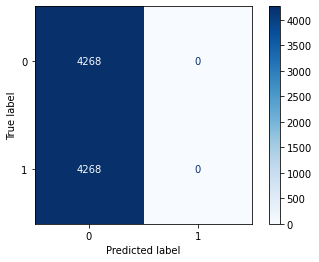

In [21]:
evb.eval_baseline(x_train,y_train)

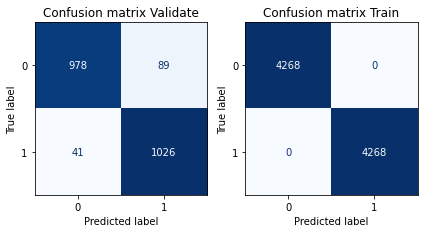

(RandomForestClassifier(random_state=8), 1.0, 0.9857644650058104)

In [52]:
evm.eval_model(RandomForestClassifier(random_state=8),x_train,y_train,x_val,y_val)

#### Massive Improvement in performance to the point of overfitting

(RandomForestClassifier(n_estimators=150, random_state=8),
 1.0,
 0.9854974444197528)

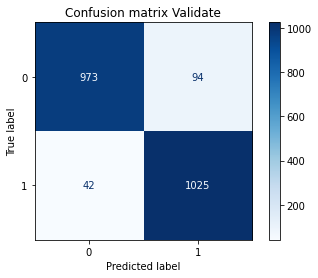

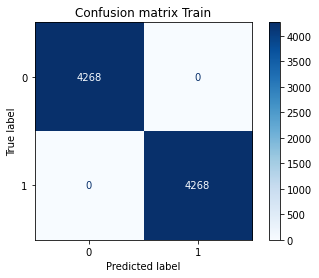

In [24]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 150),x_train,y_train,x_val,y_val)

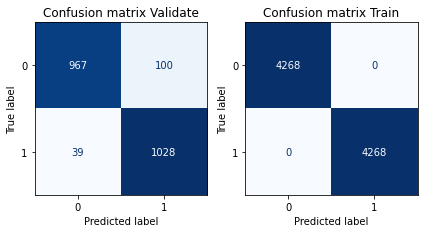

(RandomForestClassifier(n_estimators=50, random_state=8),
 1.0,
 0.9847793874161278)

In [53]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 50),x_train,y_train,x_val,y_val)

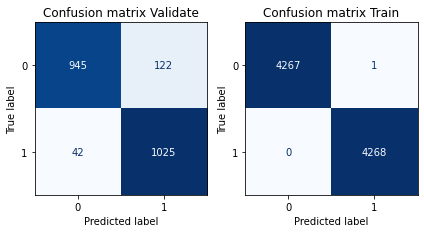

(RandomForestClassifier(n_estimators=25, random_state=8),
 1.0,
 0.9821179651274629)

In [71]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 25),x_train,y_train,x_val,y_val)

(RandomForestClassifier(n_estimators=35, random_state=8),
 1.0,
 0.9838685310090831)

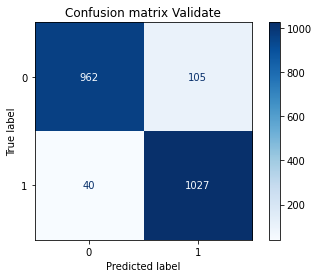

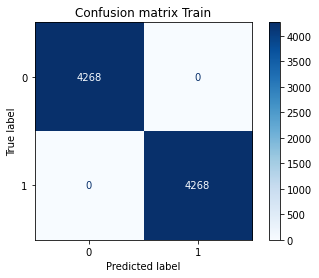

In [27]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 5),x_train,y_train,x_val,y_val)

(RandomForestClassifier(random_state=8), 1.0, 0.9857644650058104)

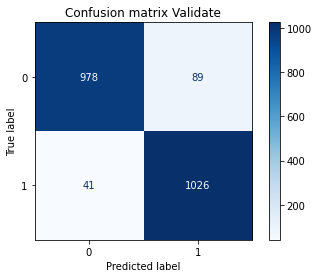

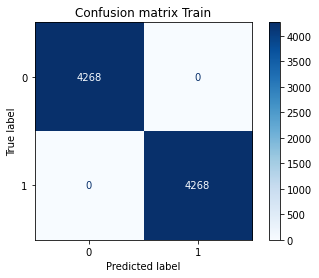

In [28]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 100),x_train,y_train,x_val,y_val)

#### N_ESTIMATORS = 25 is good for now

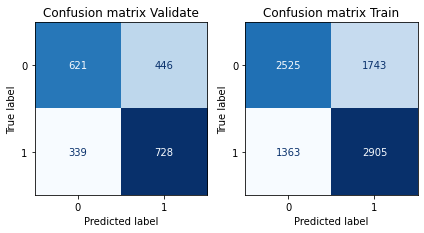

(RandomForestClassifier(max_depth=2, n_estimators=25, random_state=8),
 0.6991237398868149,
 0.6793469238613635)

In [72]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 25, max_depth = 2),x_train,y_train,x_val,y_val)

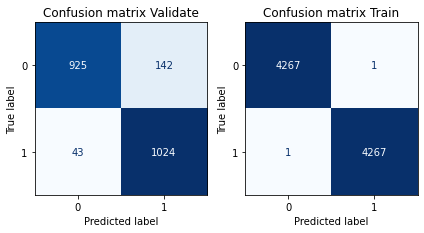

(RandomForestClassifier(max_depth=20, n_estimators=25, random_state=8),
 0.9999998902053511,
 0.9829989573900142)

In [73]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 25, max_depth = 20),x_train,y_train,x_val,y_val)

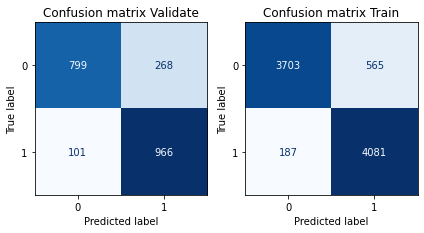

(RandomForestClassifier(max_depth=10, n_estimators=25, random_state=8),
 0.9752761664803085,
 0.9020166202747676)

In [74]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 25, max_depth = 10),x_train,y_train,x_val,y_val)

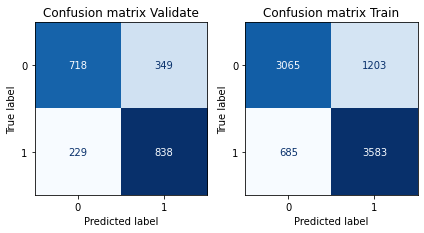

(RandomForestClassifier(max_depth=7, n_estimators=50, random_state=8),
 0.8530261930506137,
 0.7840954106715128)

In [51]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 50, max_depth = 7),x_train,y_train,x_val,y_val)

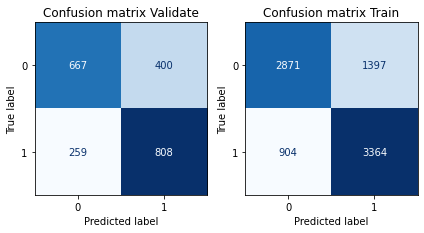

(RandomForestClassifier(max_depth=6, n_estimators=25, random_state=8),
 0.8002641000483975,
 0.7459061967221466)

In [75]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 25, max_depth = 6),x_train,y_train,x_val,y_val)

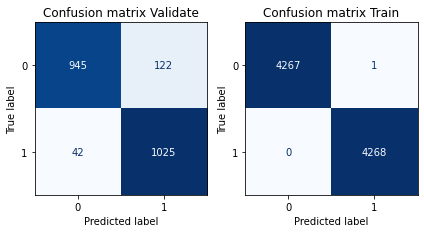

(RandomForestClassifier(max_depth=35, n_estimators=25, random_state=8),
 1.0,
 0.9821179651274629)

In [77]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 25, max_depth = 35),x_train,y_train,x_val,y_val)

#### Going with MAX_DEPTH = 20, tunning min_samples_leaf

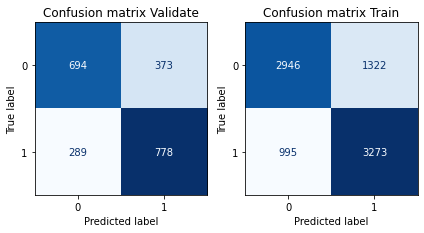

(RandomForestClassifier(max_depth=6, min_samples_leaf=2, n_estimators=50,
                        random_state=8),
 0.8025972912342588,
 0.7463348350313441)

In [58]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 50, max_depth = 6,min_samples_leaf =2 ),x_train,y_train,x_val,y_val)

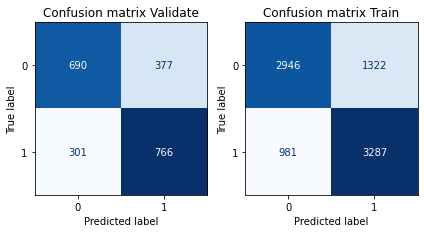

(RandomForestClassifier(max_depth=6, min_samples_leaf=5, n_estimators=50,
                        random_state=8),
 0.8007049804609444,
 0.7444674476433238)

In [59]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 50, max_depth = 6,min_samples_leaf =5 ),x_train,y_train,x_val,y_val)

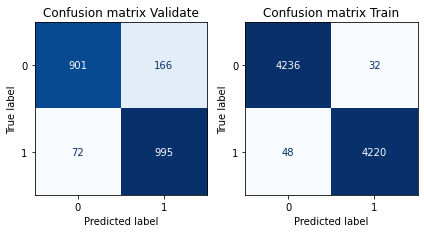

(RandomForestClassifier(max_depth=20, min_samples_leaf=3, n_estimators=25,
                        random_state=8),
 0.9994150964567949,
 0.9641880597880172)

In [78]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 25, max_depth = 20,min_samples_leaf =3 ),x_train,y_train,x_val,y_val)

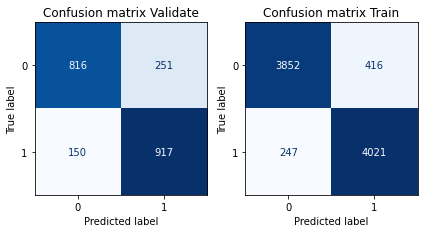

(RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=25,
                        random_state=8),
 0.9780117550542868,
 0.8918961887203127)

In [79]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 25, max_depth = 20,min_samples_leaf =10 ),x_train,y_train,x_val,y_val)

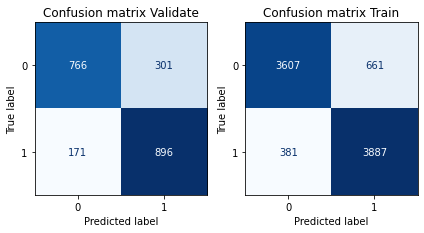

(RandomForestClassifier(max_depth=20, min_samples_leaf=15, n_estimators=25,
                        random_state=8),
 0.949401410553813,
 0.8583157149520109)

In [80]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 25, max_depth = 20,min_samples_leaf =15),x_train,y_train,x_val,y_val)

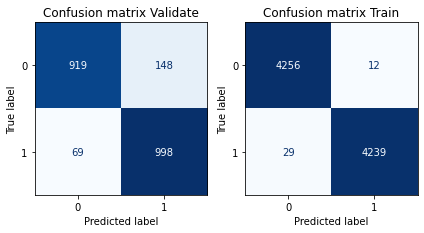

(RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=25,
                        random_state=8),
 0.9999201243929453,
 0.9711191763820293)

In [82]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 25, max_depth = 20,min_samples_leaf =2),x_train,y_train,x_val,y_val)

#### Going with min_samples_leaf = 2 tunning max_feature now

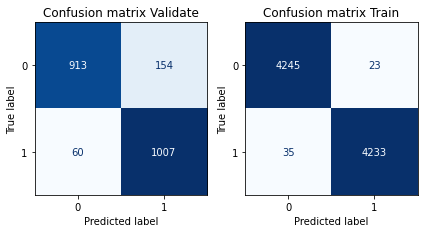

(RandomForestClassifier(max_depth=20, max_features=2, min_samples_leaf=2,
                        n_estimators=25, random_state=8),
 0.9998164782444099,
 0.9725003930648429)

In [83]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 25, max_depth = 20,min_samples_leaf =2, max_features = 2),x_train,y_train,x_val,y_val)

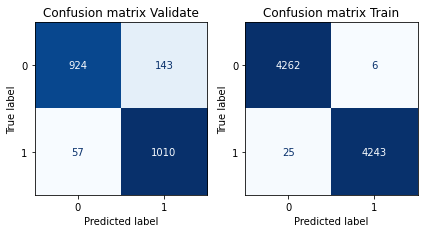

(RandomForestClassifier(max_depth=20, max_features=6, min_samples_leaf=2,
                        n_estimators=25, random_state=8),
 0.9999525687116871,
 0.9743234234147189)

In [84]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 25, max_depth = 20,min_samples_leaf =2, max_features = 6),x_train,y_train,x_val,y_val)

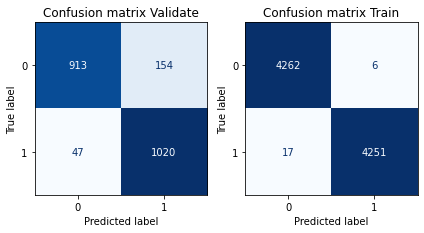

(RandomForestClassifier(max_depth=20, max_features=15, min_samples_leaf=2,
                        n_estimators=25, random_state=8),
 0.9999800448225674,
 0.9747239542938052)

In [85]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators = 25, max_depth = 20,min_samples_leaf =2, max_features = 15),x_train,y_train,x_val,y_val)

#### Got a range of best performance. Using Hyperopt to see if it can ge any better

In [102]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score , cross_validate 
space = {
    'max_depth': hp.choice('max_depth',range(3,100,1)),
    'max_features': hp.choice('max_features',range(1,15,1)),
    'min_samples_leaf': hp.choice('min_samples_leaf',range(2,14,1)),
    'n_estimators':  hp.choice('n_estimators',range(10,500,1))
}
space

{'max_depth': <hyperopt.pyll.base.Apply at 0x1bd5aef86d0>,
 'max_features': <hyperopt.pyll.base.Apply at 0x1bd60b74550>,
 'min_samples_leaf': <hyperopt.pyll.base.Apply at 0x1bd60b74b80>,
 'n_estimators': <hyperopt.pyll.base.Apply at 0x1bd60b74610>}

In [126]:
scoring = ['precision_macro', 'recall_macro', 'roc_auc', 'accuracy', 'f1']

In [127]:
cv=cross_validate(RandomForestClassifier(), x_train,y_train,cv=2, scoring=scoring)

In [129]:
print(cv)

{'fit_time': array([0.59799957, 0.59101558]), 'score_time': array([0.12996078, 0.12801027]), 'test_precision_macro': array([0.85233213, 0.84398771]), 'test_recall_macro': array([0.85098407, 0.8425492 ]), 'test_roc_auc': array([0.93360399, 0.928933  ]), 'test_accuracy': array([0.85098407, 0.8425492 ]), 'test_f1': array([0.85545455, 0.84748071])}


In [130]:
def objective(space):
   rf = RandomForestClassifier(max_depth = space['max_depth'],max_features = space['max_features'],min_samples_leaf = space['min_samples_leaf'],n_estimators = space['n_estimators'])
   cv=cross_validate(rf, x_train,y_train,cv=50, scoring=scoring)
   precision = 1-cv['test_precision_macro'].mean()
   recall = 1-cv['test_recall_macro'].mean()
   roc_auc = 1-cv['test_roc_auc'].mean()
   accuracy = 1-cv['test_accuracy'].mean()
   f1 = 1-cv['test_f1'].mean()
   acc = precision * recall * roc_auc * accuracy * f1
   return{'loss': acc, 'status': STATUS_OK }

best = fmin(
   fn=objective,  
   space=space,      
   algo=tpe.suggest,      
   max_evals=5
)

100%|█████████████████████████████████████████████| 5/5 [25:47<00:00, 309.57s/trial, best loss: 1.9599797930200944e-05]


In [131]:
best

{'max_depth': 26,
 'max_features': 5,
 'min_samples_leaf': 6,
 'n_estimators': 378}

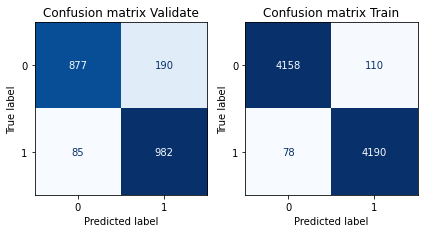

(RandomForestClassifier(max_depth=26, max_features=5, min_samples_leaf=6,
                        n_estimators=378, random_state=8),
 0.9973702534675347,
 0.9479828087930582)

In [133]:
rf_upsample_mod = RandomForestClassifier(random_state=8,n_estimators = 378, max_depth = 26,min_samples_leaf =6, max_features = 5)
evm.eval_model(rf_upsample_mod,x_train,y_train,x_val,y_val)

(0.956720665154679,
 0.8875562218890555,
 0.8923187365398421,
 0.8560606060606061,
 0.931784107946027,
 0.8875562218890555)

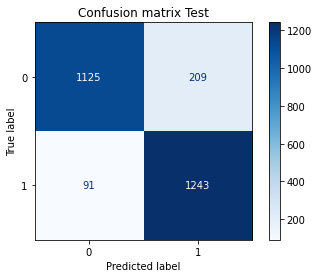

In [137]:
evm.get_performance(rf_upsample_mod, x_test, y_test, "Test", True)

#### Pretty Good Score with Up Sampling.

### Lets see if Down Sample give a better score

In [141]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled[['TARGET_5Yrs','TARGET_5Yrs_Inv']].value_counts()

TARGET_5Yrs  TARGET_5Yrs_Inv
0            1                  1331
1            0                  1331
dtype: int64

In [186]:
x=df_downsampled.drop(['TARGET_5Yrs','TARGET_5Yrs_Inv'],axis=1)
y=df_downsampled['TARGET_5Yrs_Inv']

x_data , x_test ,y_data,  y_test = train_test_split(x, y, test_size=0.2, random_state = 8, stratify=y)
x_train , x_val , y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state = 8, stratify=y_data)

print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

0    852
1    851
Name: TARGET_5Yrs_Inv, dtype: int64
0    213
1    213
Name: TARGET_5Yrs_Inv, dtype: int64
1    267
0    266
Name: TARGET_5Yrs_Inv, dtype: int64


Accuracy Score:  0.5002935995302408  F1 Score  0.0  Precision Score  0.0  Recall Score  0.0 (BASELINE)


c:\users\xauspi\.virtualenvs\kaggle_assignment-dq2gjalz\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


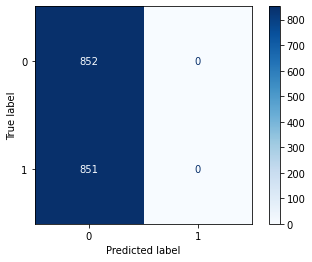

In [187]:
evb.eval_baseline(x_train,y_train)

#### Start with Default Hyperparam

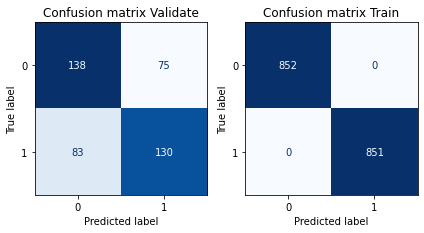

(RandomForestClassifier(random_state=8), 1.0, 0.7018669135312658)

In [188]:
evm.eval_model(RandomForestClassifier(random_state=8),x_train,y_train,x_val,y_val)

#### tunning n_estimators

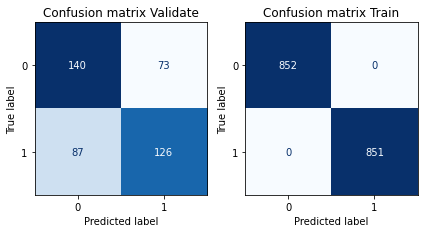

(RandomForestClassifier(n_estimators=25, random_state=8),
 1.0,
 0.6745905794705637)

In [193]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=25 ),x_train,y_train,x_val,y_val)

Score are getting better but continuing to see the impact

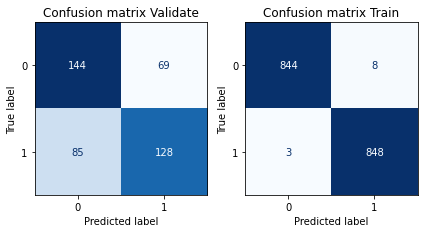

(RandomForestClassifier(n_estimators=15, random_state=8),
 0.999839321869328,
 0.6674381185390905)

In [194]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=15 ),x_train,y_train,x_val,y_val)

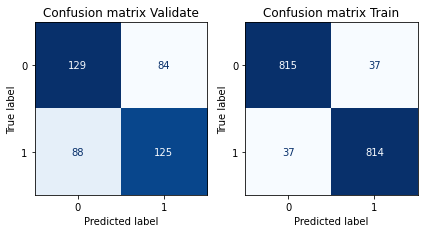

(RandomForestClassifier(n_estimators=5, random_state=8),
 0.9901613953206114,
 0.632634618351738)

In [195]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=5 ),x_train,y_train,x_val,y_val)

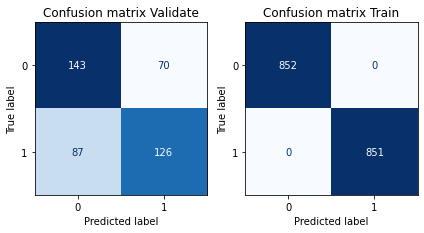

(RandomForestClassifier(n_estimators=50, random_state=8),
 1.0,
 0.6902730939628381)

In [196]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=50 ),x_train,y_train,x_val,y_val)

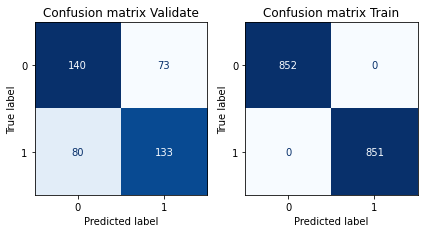

(RandomForestClassifier(n_estimators=150, random_state=8),
 1.0,
 0.7075536159051335)

In [197]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=150 ),x_train,y_train,x_val,y_val)

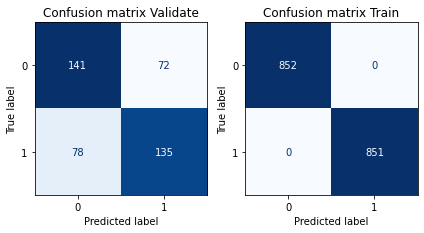

(RandomForestClassifier(n_estimators=250, random_state=8),
 1.0,
 0.7109810663669025)

In [198]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=250 ),x_train,y_train,x_val,y_val)

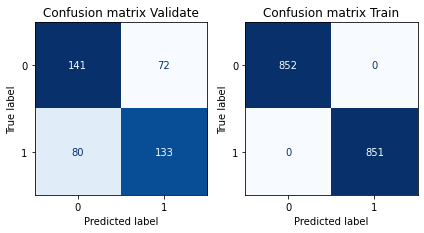

(RandomForestClassifier(n_estimators=350, random_state=8),
 1.0,
 0.7094932663272279)

In [199]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=350 ),x_train,y_train,x_val,y_val)

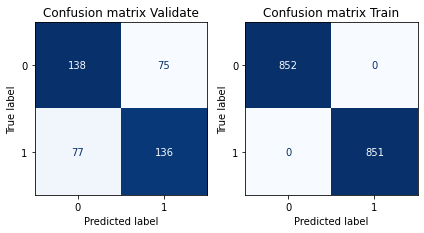

(RandomForestClassifier(n_estimators=275, random_state=8),
 1.0,
 0.7097577641120589)

In [200]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=275 ),x_train,y_train,x_val,y_val)

#### Going with n_estimator = 250, Tunning max_depth

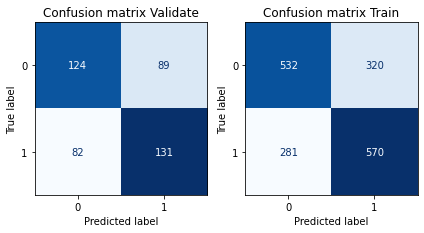

(RandomForestClassifier(max_depth=2, n_estimators=250, random_state=8),
 0.7115889618951469,
 0.6769159558288699)

In [201]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=250, max_depth = 2 ),x_train,y_train,x_val,y_val)

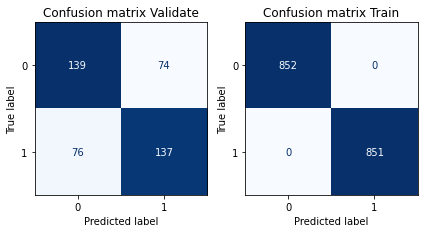

(RandomForestClassifier(max_depth=20, n_estimators=250, random_state=8),
 1.0,
 0.7134937953227976)

In [202]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=250, max_depth = 20 ),x_train,y_train,x_val,y_val)

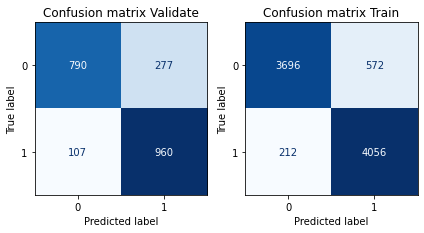

(RandomForestClassifier(max_depth=10, n_estimators=20, random_state=8),
 0.9726270960896416,
 0.8989573021785893)

In [153]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=20, max_depth = 10 ),x_train,y_train,x_val,y_val)

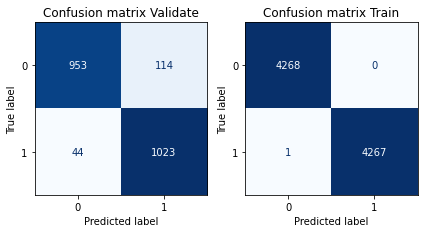

(RandomForestClassifier(max_depth=25, n_estimators=20, random_state=8),
 0.9999999451026755,
 0.9843893968233334)

In [154]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=20, max_depth = 25 ),x_train,y_train,x_val,y_val)

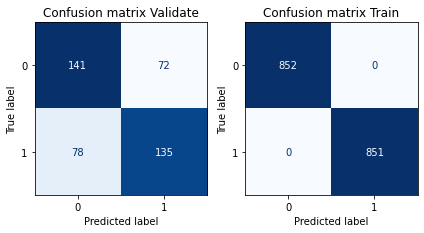

(RandomForestClassifier(max_depth=50, n_estimators=250, random_state=8),
 1.0,
 0.7109810663669025)

In [203]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=250, max_depth = 50 ),x_train,y_train,x_val,y_val)

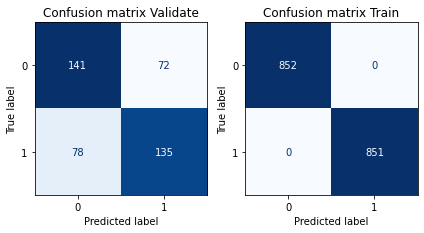

(RandomForestClassifier(max_depth=100, n_estimators=250, random_state=8),
 1.0,
 0.7109810663669025)

In [204]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=250, max_depth = 100 ),x_train,y_train,x_val,y_val)

#### It has to be 20 or more, Tunning min_samples_leaf

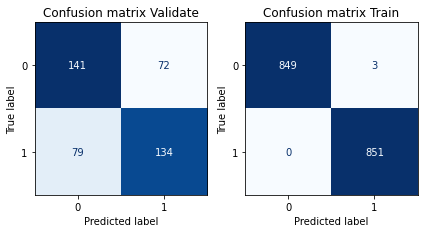

(RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=250,
                        random_state=8),
 0.9999903455200454,
 0.7101545107893055)

In [205]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=250, max_depth = 20, min_samples_leaf =2 ),x_train,y_train,x_val,y_val)

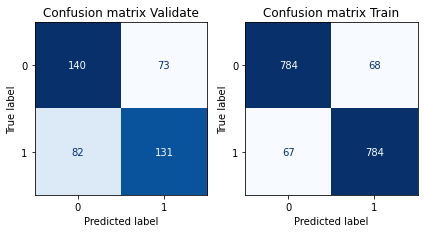

(RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=250,
                        random_state=8),
 0.9824647059797091,
 0.7032114439374904)

In [206]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=250, max_depth = 20, min_samples_leaf =5 ),x_train,y_train,x_val,y_val)

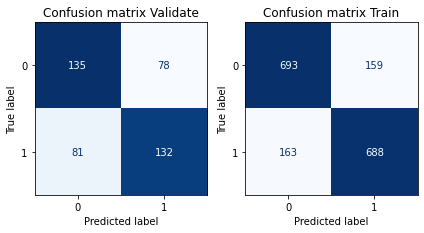

(RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=250,
                        random_state=8),
 0.9067046225650023,
 0.6965549163525755)

In [207]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=250, max_depth = 20, min_samples_leaf =10 ),x_train,y_train,x_val,y_val)

#### has to be min_samples_leaf = 10, Tunning max_features

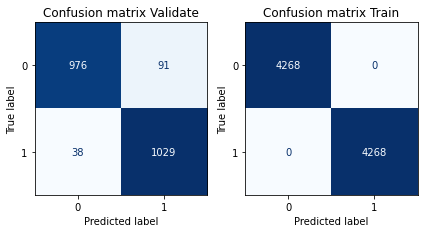

(RandomForestClassifier(max_depth=50, max_features=2, n_estimators=20,
                        random_state=8),
 1.0,
 0.9828601769538398)

In [163]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=20, max_depth = 50, min_samples_leaf =1 , max_features = 2),x_train,y_train,x_val,y_val)

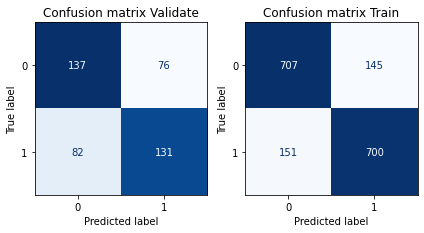

(RandomForestClassifier(max_depth=20, max_features=6, min_samples_leaf=10,
                        n_estimators=250, random_state=8),
 0.9163949620165175,
 0.697370451189138)

In [208]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=250, max_depth = 20, min_samples_leaf =10 , max_features = 6),x_train,y_train,x_val,y_val)

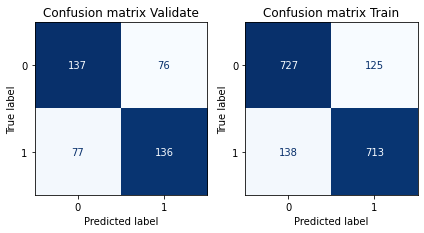

(RandomForestClassifier(max_depth=20, max_features=15, min_samples_leaf=10,
                        n_estimators=250, random_state=8),
 0.9358735649305152,
 0.6902290109986995)

In [209]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=250, max_depth = 20, min_samples_leaf =10 , max_features = 15),x_train,y_train,x_val,y_val)

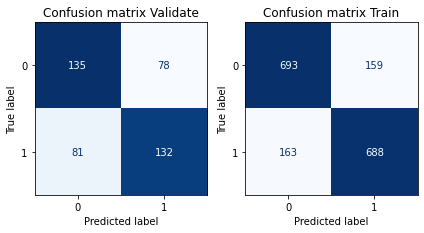

(RandomForestClassifier(max_depth=20, max_features=4, min_samples_leaf=10,
                        n_estimators=250, random_state=8),
 0.9067046225650023,
 0.6965549163525755)

In [210]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=250, max_depth = 20, min_samples_leaf =10 , max_features = 4),x_train,y_train,x_val,y_val)

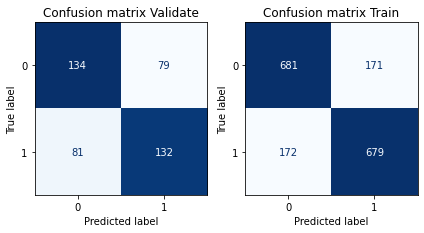

(RandomForestClassifier(max_depth=20, max_features=3, min_samples_leaf=10,
                        n_estimators=250, random_state=8),
 0.8975907934879154,
 0.7001256364477948)

In [211]:
evm.eval_model(RandomForestClassifier(random_state=8,n_estimators=250, max_depth = 20, min_samples_leaf =10 , max_features = 3),x_train,y_train,x_val,y_val)

#### Uscoring = ['precision_macro', 'recall_macro', 'roc_auc', 'accuracy', 'f1']sing max_features = 6, hyperopt to see if it can get any better

In [220]:
# scoring = ['precision_macro', 'recall_macro', 'roc_auc', 'accuracy', 'f1']
scoring = ['roc_auc']

In [221]:
space = {
    'max_depth': hp.choice('max_depth',range(3,100,1)),
    'max_features': hp.choice('max_features',range(1,15,1)),
    'min_samples_leaf': hp.choice('min_samples_leaf',range(1,14,1)),
    'n_estimators':  hp.choice('n_estimators',range(10,500,1))
}
space

{'max_depth': <hyperopt.pyll.base.Apply at 0x1bd6ab3cac0>,
 'max_features': <hyperopt.pyll.base.Apply at 0x1bd650e2c40>,
 'min_samples_leaf': <hyperopt.pyll.base.Apply at 0x1bd60b166d0>,
 'n_estimators': <hyperopt.pyll.base.Apply at 0x1bd60b16370>}

In [222]:
def objective(space):
   rf = RandomForestClassifier(max_depth = space['max_depth'],max_features = space['max_features'],min_samples_leaf = space['min_samples_leaf'],n_estimators = space['n_estimators'])
   cv=cross_validate(rf, x_train,y_train,cv=50, scoring=scoring)
#    precision = 1-cv['test_precision_macro'].mean()
#    recall = 1-cv['test_recall_macro'].mean()
   roc_auc = 1-cv['test_roc_auc'].mean()
#    accuracy = 1-cv['test_accuracy'].mean()
#    f1 = 1-cv['test_f1'].mean()
#    acc = precision * recall * roc_auc * accuracy * f1
   acc = roc_auc
   return{'loss': acc, 'status': STATUS_OK }

best = fmin(
   fn=objective,  
   space=space,      
   algo=tpe.suggest,      
   max_evals=5
)

100%|█████████████████████████████████████████████████| 5/5 [03:29<00:00, 41.99s/trial, best loss: 0.30650134563629383]


In [223]:
best

{'max_depth': 2,
 'max_features': 10,
 'min_samples_leaf': 11,
 'n_estimators': 230}

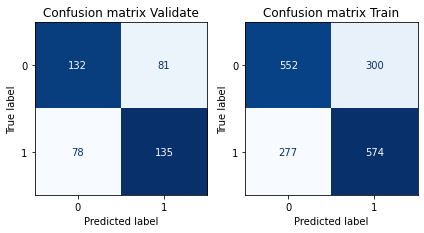

(RandomForestClassifier(max_depth=2, max_features=10, min_samples_leaf=11,
                        n_estimators=230, random_state=8),
 0.7179829860478975,
 0.688708148735921)

In [226]:
rf_dowmsample_mod = RandomForestClassifier(random_state=8,n_estimators = 230, max_depth = 2,min_samples_leaf =11, max_features = 10)
evm.eval_model(rf_dowmsample_mod,x_train,y_train,x_val,y_val)

(0.6856889414547604,
 0.6210131332082551,
 0.6115384615384616,
 0.6284584980237155,
 0.5955056179775281,
 0.6210131332082551)

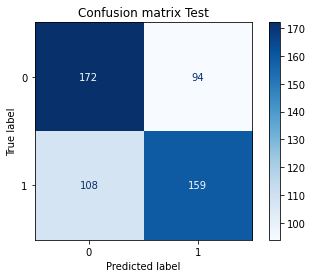

In [227]:
evm.get_performance(rf_dowmsample_mod, x_test, y_test, "Test", True)

## Down Sample has performed better than the Upsampled model.

In [228]:
# dump(rf_upsample_mod,  '../models/sp_wk2_upsample_model.joblib')
dump(rf_dowmsample_mod,  '../models/sp_wk2_downsample_model.joblib')

['../models/sp_wk2_downsample_model.joblib']

In [181]:
importanceup=rf_upsample_mod.feature_importances_
feature_name = x.columns
sorted_idx = rf_upsample_mod.feature_importances_.argsort()
sorted_idx

array([ 5, 14, 13,  6, 15, 16,  9, 10,  7, 12,  4,  8,  3, 18, 11,  2,  1,
       17,  0], dtype=int64)

Text(0.5, 0, 'Random Forest Feature Importance')

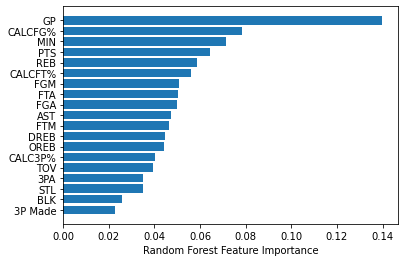

In [182]:
from matplotlib import pyplot as plt
plt.barh(feature_name[sorted_idx], importanceup[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [218]:
importancedw=rf_dowmsample_mod.feature_importances_
# feature_name = x_col_name
sorted_idx = rf_dowmsample_mod.feature_importances_.argsort()
sorted_idx

array([ 5, 16,  6, 18, 13, 14, 12, 15,  4, 10, 17,  9,  1,  7,  3, 11,  2,
        8,  0], dtype=int64)

Text(0.5, 0, 'Random Forest Feature Importance')

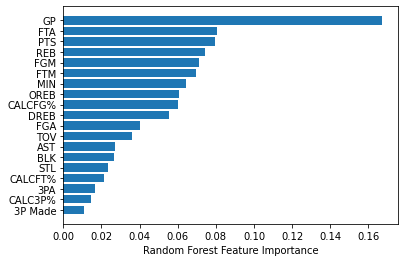

In [219]:
from matplotlib import pyplot as plt
plt.barh(feature_name[sorted_idx], importancedw[sorted_idx])
plt.xlabel("Random Forest Feature Importance")